# Modules imports

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import cv2
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # ignore TF unsupported NUMA warnings

# Filter out TFA warning
import warnings
warnings.filterwarnings("ignore", message="TFA has entered a minimal maintenance and release mode", category=Warning)

import tensorflow as tf
import tensorflow_addons as tfa


# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
   tf.config.experimental.set_memory_growth(gpu, True)


c:\Users\jacop\Desktop\DL_Project\.venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Hyperparameters

In [2]:
# Chose here the fixed image-label pair you want to train on
fixed_image_path = "/mnt/c/Users/jacop/Desktop/DL_Project/1124.jpg"
fixed_label_path = "/mnt/c/Users/jacop/Desktop/DL_Project/1124.txt"

BATCH_SIZE = 3
EPOCHS = 100

# Adam Hyperparameters
LR=0.001
BETA_1=0.9
BETA_2=0.999
EPSILON=1e-07

# Importing dataset

In [3]:
print("Started dataset loading...")

input_path = "/mnt/c/Users/jacop/Desktop/DL_Project/processed_dataset/" #if in wsl
#input_path = "/mnt/c/Users/vitto/Desktop/DL project/DL project github/processed_dataset/" #if in wsl
#input_path = r"C:\Users\vitto\Desktop\DL project\DL project github\processed_dataset"  # if in windows
#input_path = r"C:\Users\jacop\Desktop\DL_Project\processed_dataset"  # if in windows




# =========== Images =========== #

# Define the image processing function
def process_image(x):
    # Read the image file's content as a sequence of bytes
    byte_img = tf.io.read_file(x)
    # Decode the image using the JPEG format
    img = tf.io.decode_jpeg(byte_img)
    # Convert images to grayscale
    img = tf.image.rgb_to_grayscale(img)
    img = tf.squeeze(img, axis=-1)
    # Normalize pixel values to the range [0, 1]
    img = img / 255
    return img


# Create train, test, val datasets and process the images
train_images = tf.data.Dataset.list_files(input_path + "/images/train/*.jpg", shuffle=False)
train_images = train_images.map(process_image)

test_images = tf.data.Dataset.list_files(input_path + "/images/test/*.jpg", shuffle=False)
test_images = test_images.map(process_image)

val_images = tf.data.Dataset.list_files(input_path + "/images/val/*.jpg", shuffle=False)
val_images = val_images.map(process_image)

# Processing the fixed image
fixed_image = tf.data.Dataset.list_files(fixed_image_path, shuffle=False)
fixed_image = fixed_image.map(process_image)

# =========== Labels =========== #

# Define a function to load labels from a text file
def load_labels(path):
    # Initialize an empty list for labels
    landmarks = []

    # Open the label file specified by `path` in read mode with "utf-8" encoding
    with open(path.numpy(), "r", encoding="utf-8") as file:
        # Skip the first line in the file
        next(file, None)

        # Iterate through the remaining lines in the file
        for line in file:
            # Split each line into columns using the tab character '\t' as a delimiter
            columns = line.strip().split("\t")

            # Extract X and Y values from columns 1 and 2 (using 0-based indexing)
            # and convert them to floating-point values. Also, normalize them by dividing by 256.
            x_value = float(columns[1]) / 256
            y_value = float(columns[2]) / 256

            # Add the normalized X and Y values to the `landmarks` list
            landmarks.extend([x_value, y_value])

    # Convert `landmarks` to a NumPy array
    return np.array(landmarks)


# Create train, test and val label dataset and load their labels using the corresponding function
train_labels = tf.data.Dataset.list_files(input_path + "/labels/train/*.txt", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

test_labels = tf.data.Dataset.list_files(input_path + "/labels/test/*.txt", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

val_labels = tf.data.Dataset.list_files(input_path + "/labels/val/*.txt", shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

# Processing the fixed image's labels
fixed_label = tf.data.Dataset.list_files(fixed_label_path, shuffle=False)
fixed_label = fixed_label.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))



# =========== Combine Images and Labels =========== #

# Combining images and labels
train_dataset = tf.data.Dataset.zip((train_images, train_labels)).shuffle(1000)
test_dataset = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000)
val_dataset = tf.data.Dataset.zip((val_images, val_labels)).shuffle(1000)

fixed_dataset = tf.data.Dataset.zip((fixed_image,fixed_label))

2023-10-27 11:30:00.472451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 11:30:00.473038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 11:30:00.473490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 11:30:01.075095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-27 11:30:01.075627: I tensorflow/compile

Started dataset loading...


# U-Net

Creating generators

In [4]:
print("Started U-Net training...")
 
# We only need images in this part
train_images_only = train_dataset.map(lambda img, lbl: img)
test_images_only = test_dataset.map(lambda img, lbl: img)
val_images_only = val_dataset.map(lambda img, lbl: img)
fixed_image_only = fixed_dataset.map(lambda img, lbl: img)


train_list = list(train_images_only)
val_list = list(val_images_only)
test_list = list(test_images_only)

fixed_image = list(fixed_image_only)[0]

def train_image_generator():
    for moving_image in train_list:

        # Combine fixed and moving images into a single tensor
        combined_image = tf.stack([fixed_image,moving_image],-1)
        yield (combined_image, fixed_image)


# Create a TensorFlow dataset from the generator
train_images_dataset = tf.data.Dataset.from_generator(
    train_image_generator,
    output_signature=(tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
                      tf.TensorSpec(shape=(256, 256), dtype=tf.float32))
    )
train_images_dataset = train_images_dataset.batch(BATCH_SIZE)


# Create a generator function to yield the combined image tensor for validation
def val_image_generator():
    for moving_image in val_list:
        
        combined_image = tf.stack([fixed_image, moving_image], -1)
        yield (combined_image, fixed_image)

# Create a TensorFlow dataset from the generator for validation
val_images_dataset = tf.data.Dataset.from_generator(
    val_image_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256), dtype=tf.float32)
    )
)

val_images_dataset = val_images_dataset.batch(BATCH_SIZE)


# Create a generator function to yield the combined image tensor for test
def test_image_generator():
    for moving_image in test_list:
        
        combined_image = tf.stack([fixed_image, moving_image], -1)
        yield (combined_image, fixed_image)

# Create a TensorFlow dataset from the generator for validation
test_images_dataset = tf.data.Dataset.from_generator(
    test_image_generator,
    output_signature=(
        tf.TensorSpec(shape=(256, 256, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(256, 256), dtype=tf.float32)
    )
)
test_images_dataset = test_images_dataset.batch(BATCH_SIZE)

Started U-Net training...


U-net architecture

In [5]:
input_shape = (256, 256, 2)


# Due immagini, una fixed e una moving, prese come input
input = tf.keras.layers.Input(shape=input_shape)

### Downsampling path ###

# Applicazione della funzione di attivazione Leaky ReLU con coefficiente alpha
a1 = tf.keras.layers.LeakyReLU(alpha=0.01)(input)

# Applicazione di un layer di convoluzione 2D con 64 filtri di dimensione 3x3
c1 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))(a1)

bn1 = tf.keras.layers.BatchNormalization()(c1)

# Appli#cazione del layer di Dropout con un tasso di dropout del 10%
c1 = tf.keras.layers.Dropout(0.1)(c1)

# Applicazione del max-pooling con una finestra di pooling di dimensione 2x2
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)


a2 = tf.keras.layers.LeakyReLU(alpha=0.01)(p1)
c2 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))(a2)
bn2 = tf.keras.layers.BatchNormalization()(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2)

a3 = tf.keras.layers.LeakyReLU(alpha=0.01)(p2)
c3 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))(a3)
bn3 = tf.keras.layers.BatchNormalization()(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c3)

a4 = tf.keras.layers.LeakyReLU(alpha=0.01)(p3)
c4 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))(a4)
bn4 = tf.keras.layers.BatchNormalization()(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

a5 = tf.keras.layers.LeakyReLU(alpha=0.01)(p4)
c5 = tf.keras.layers.Conv2D(1024, 3, padding="same", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.0001))(a5)
bn5 = tf.keras.layers.BatchNormalization()(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)

### Upsampling path ###

# Decodifica dell'output dell'encoder con la trasposizione della convoluzione 2D
u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = tf.keras.layers.concatenate(
    [u6, c4]
)  # Concatenazione dell'output con gli strati dell'encoder precedenti
a6 = tf.keras.layers.LeakyReLU(alpha=0.01)(u6)  # Applicazione di Leaky ReLU
c6 = tf.keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_normal")(
    a6
)  # Convoluzione 2D
c6 = tf.keras.layers.Dropout(0.3)(c6)  # Applicazione di Dropout

u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
a7 = tf.keras.layers.LeakyReLU(alpha=0.01)(u7)
c7 = tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer="he_normal")(a7)
c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
a8 = tf.keras.layers.LeakyReLU(alpha=0.01)(u8)
c8 = tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_normal")(a8)
c8 = tf.keras.layers.Dropout(0.2)(c8)

u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
a9 = tf.keras.layers.LeakyReLU(alpha=0.01)(u9)
c9 = tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_normal")(a9)
c9 = tf.keras.layers.Dropout(0.1)(c9)

# Creazione dell'output finale del modello
c10 = tf.keras.layers.Conv2D(2, 1, padding="same", kernel_initializer="he_normal")(c9)

# Creazione di un tensore di deformazione
displacement_tensor = tf.keras.layers.Conv2D(
    2, kernel_size=3, activation='linear', padding="same", name="disp"
)(c10)

# Define the function to extract the "bottom" tensor
def extract_moving_img(input):
    return input[:, :, :, 1:2]

moving_image = tf.keras.layers.Lambda(extract_moving_img)(input)

# Creazione di una funzione per applicare la trasformazione di deformazione all'immagine di input
def apply_deformation(inputs):
    #unpacking dell'input
    image, displacement_tensor = inputs
    # Applica la trasformazione di deformazione all'immagine di input utilizzando il tensore di deformazione
    deformed_image = tfa.image.dense_image_warp(image, displacement_tensor)
    return deformed_image
def_image = tf.keras.layers.Lambda(apply_deformation)([moving_image,displacement_tensor])

output = def_image

Model Initialization

In [6]:
# Create the U-Net model
unet = tf.keras.Model(inputs=input, outputs=output)

def custom_mse_loss(y_true, y_pred):
    # Calcola l'errore quadratico medio tra i tensori y_true e y_pred
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse


# Define the callback to reduce the learning rate when the validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001, amsgrad=False)


adam = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)

unet.compile(optimizer=adam, loss='mse', metrics='mse')

Model Training

Epoch 1/100


2023-10-27 11:30:29.312813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-27 11:30:31.085104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-27 11:30:35.137333: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc995e0d580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-27 11:30:35.137381: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-10-27 11:30:35.146377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-27 11:30:35.259906: I ./tensorflow/compiler/jit/device_compiler.h:186

    258/Unknown - 32s 75ms/step - loss: 0.3308 - mse: 0.1092

2023-10-27 11:30:59.546584: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13356089708283649914
2023-10-27 11:30:59.546671: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 17465445906109337924
2023-10-27 11:30:59.546695: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1691968007272640693
2023-10-27 11:30:59.546725: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 11300302452096222141
2023-10-27 11:30:59.546732: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10825584613942068059
2023-10-27 11:30:59.546747: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15312086429860259281
2023-10-27 11:30:59.546751: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous sen

258/258 [==============================] - 36s 89ms/step - loss: 0.3308 - mse: 0.1092 - val_loss: 0.2385 - val_mse: 0.1034 - lr: 1.0000e-04
Epoch 2/100


2023-10-27 11:31:03.330177: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6410799946824075365
2023-10-27 11:31:03.330233: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8137747927456255457
2023-10-27 11:31:03.330242: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6855398507154382275


258/258 [==============================] - 22s 84ms/step - loss: 0.1849 - mse: 0.0781 - val_loss: 0.1634 - val_mse: 0.0755 - lr: 1.0000e-04
Epoch 3/100
258/258 [==============================] - 22s 84ms/step - loss: 0.1447 - mse: 0.0665 - val_loss: 0.1361 - val_mse: 0.0653 - lr: 1.0000e-04
Epoch 4/100
258/258 [==============================] - 22s 84ms/step - loss: 0.1224 - mse: 0.0563 - val_loss: 0.1191 - val_mse: 0.0571 - lr: 1.0000e-04
Epoch 5/100
258/258 [==============================] - 22s 84ms/step - loss: 0.1097 - mse: 0.0510 - val_loss: 0.1074 - val_mse: 0.0516 - lr: 1.0000e-04
Epoch 6/100
258/258 [==============================] - 22s 83ms/step - loss: 0.1015 - mse: 0.0480 - val_loss: 0.1015 - val_mse: 0.0500 - lr: 1.0000e-04
Epoch 7/100
258/258 [==============================] - 22s 84ms/step - loss: 0.0945 - mse: 0.0449 - val_loss: 0.0944 - val_mse: 0.0467 - lr: 1.0000e-04
Epoch 8/100
258/258 [==============================] - 22s 83ms/step - loss: 0.0892 - mse: 0.0429 - 

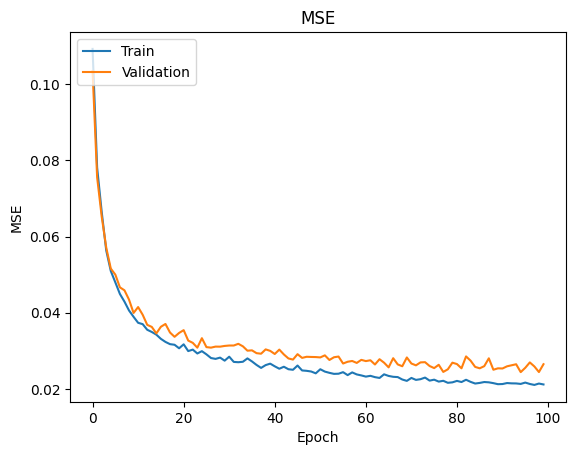

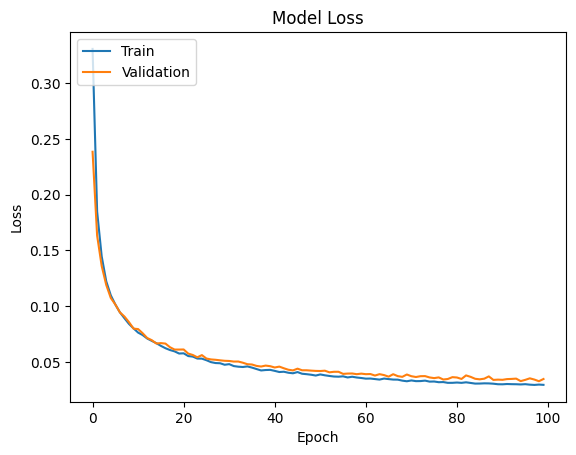

<Figure size 640x480 with 0 Axes>

In [7]:
# Train the model
history = unet.fit(train_images_dataset, epochs=EPOCHS, validation_data=val_images_dataset, callbacks=[reduce_lr])

# Plot training & validation accuracy values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('mse.png')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('loss.png')

# Saving model

In [10]:
# Salva il modello

model_name = 'unet_100epochs.keras'
unet.save(model_name)

print('Model saved as', model_name)

Model saved as unet_100epochs.keras


# Loading the model

In [29]:
# Carica il modello

loaded_model = tf.keras.models.load_model(model_name, safe_mode=False)
#loaded_model = tf.keras.models.load_model(model_name, custom_objects={'custom_mse_loss': custom_mse_loss})


# Testing the model


In [ ]:
# Evaluate the model on the test dataset
print("Evaluate on test data")
results = unet.evaluate(test_images_dataset)
print("Test loss, Test accuracy:", results)

Obtaining the deformed image directly via the U-Net

1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'overlapping image')

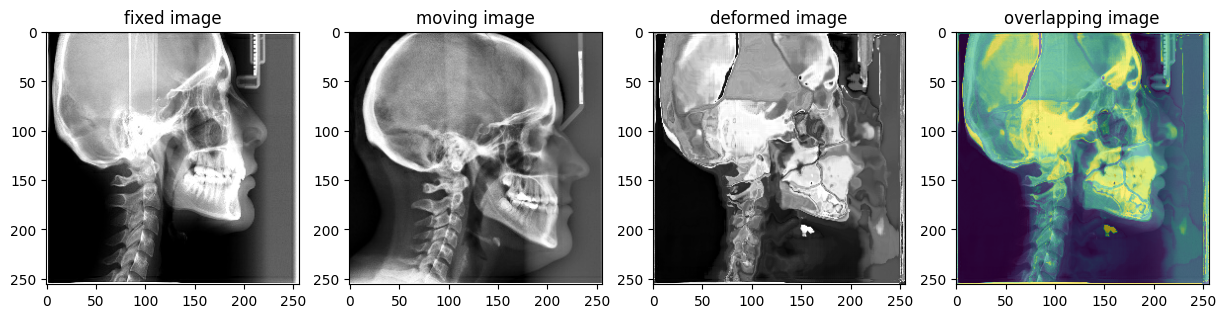

In [8]:
test_image_list = list(test_images_only)
test_image = test_image_list[30]
test_feed = tf.stack([fixed_image, test_image],-1)
test_feed = tf.expand_dims(test_feed, axis=0)

unet = loaded_model

results = unet.predict(test_feed)

predicted_image = results[0, :, :, 0]  # Extract the 2D image from the batch

fig, axs = plt.subplots(1, 4, figsize=(15, 15))  # Adjust the figsize as needed

axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title('fixed image')

axs[1].imshow(test_image, cmap = 'gray')
axs[1].set_title('moving image')

axs[2].imshow(predicted_image, cmap= 'gray')
axs[2].set_title('deformed image')

axs[3].imshow(fixed_image,cmap='gray')
axs[3].imshow(predicted_image, alpha = 0.6)
axs[3].set_title('overlapping image')


# Extracting the displacement tensor

In [ ]:
unet = loaded_model

displacement_model = tf.keras.Model(inputs=unet.input,
                                 outputs=unet.get_layer('disp').output)
displacement_model_output = displacement_model.predict(test_feed)

# expand the test_image to match displacement_model_output dimensions
test_image_expanded = np.expand_dims(test_image, axis=0)
test_image_expanded = np.expand_dims(test_image_expanded, axis=3)

deformed_image = tfa.image.dense_image_warp(test_image_expanded, displacement_model_output)

#displacement_tensor = displacement_model_output[0]  # Remove the batch dimension
fig, axs = plt.subplots(1, 4, figsize=(15, 15))  # Adjust the figsize as needed
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title('fixed image')

axs[1].imshow(test_image, cmap = 'gray')
axs[1].set_title('moving image')

axs[2].imshow(deformed_image[0], cmap= 'gray')
axs[2].set_title('deformed image')

axs[3].imshow(fixed_image,cmap='gray')
axs[3].imshow(deformed_image[0], alpha = 0.4)
axs[3].set_title('overlapping image')



In [ ]:

inverse_displacement = -displacement_model.predict(test_feed)

# the inverse displacement represent the traslation (pixel per pixel) of the fixed image onto the moving one.
# thus, if we apply it to the coordinates of the landmarks of the fixed img, we should obtain the (approximate) position of those in the moving img